In [25]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

## サンプルデータセットの生成

In [49]:
np.random.seed(42)
n_samples = 200

# 基本情報
df = pd.DataFrame({
    "horse_id": np.arange(n_samples),
    "age": np.random.randint(2, 10, size=n_samples),
    "weight": np.random.randint(400, 600, size=n_samples),
})

# -----------------------------
# 相関を持たせるためのスコア計算
# -----------------------------

# 年齢は4歳が最も強い → 4 からの距離が大きいほど弱い
age_score = np.abs(df["age"] - 4)

# 体重は軽いほど強い → 400kg が最強と仮定
weight_score = (df["weight"] - 400) / 50  # 50kg で1ポイント弱くなるイメージ

# 総合スコア（小さいほど強い）
strength_score = age_score + weight_score
df["strength_score"] = strength_score # 特徴量には含めないが確認用に保存

# -----------------------------
# odds と finish_position を生成
# -----------------------------

# odds：強いほど（score 小）1に近づく、弱いほど大きくなる
df["odds"] = 1.0 + (strength_score.max() - strength_score) * np.random.uniform(0.5, 2.0, size=n_samples)

# 順位：強いほど1に近づく
base_position = (strength_score.max() - strength_score) * np.random.uniform(0.5, 2.0, size=n_samples)
noise = np.random.normal(0, 1.5, size=n_samples) # ランダム性を追加
df["finish_position"] = np.clip(1 + base_position + noise, 1, 18).astype(int)

# 3着以内を target=1 とする
df["target"] = (df["finish_position"] <= 3).astype(int)

In [50]:
df
df["target"].sum()

np.int64(58)

## サンプルデータの可視化

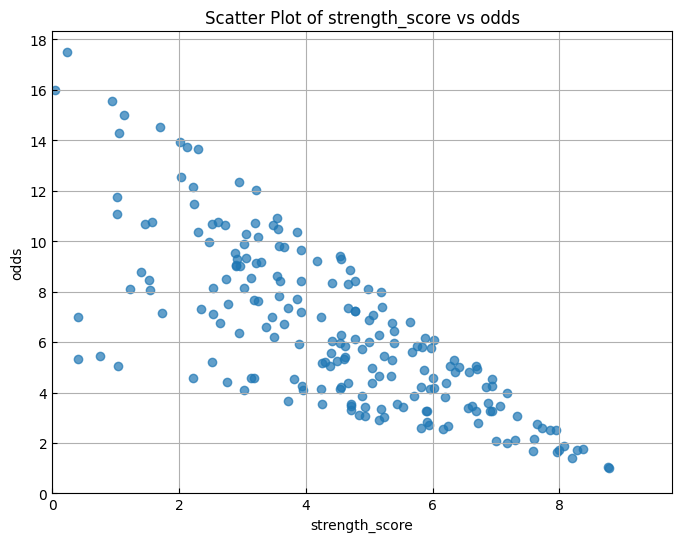

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df["strength_score"], df["odds"], alpha=0.7)

plt.xlabel("strength_score")
plt.ylabel("odds")
plt.title("Scatter Plot of strength_score vs odds")
plt.xlim(0, df["strength_score"].max()+1)
plt.tick_params(direction='in')
plt.yticks(np.arange(0, df["odds"].max()+1, 2))

plt.grid(True)
plt.show()

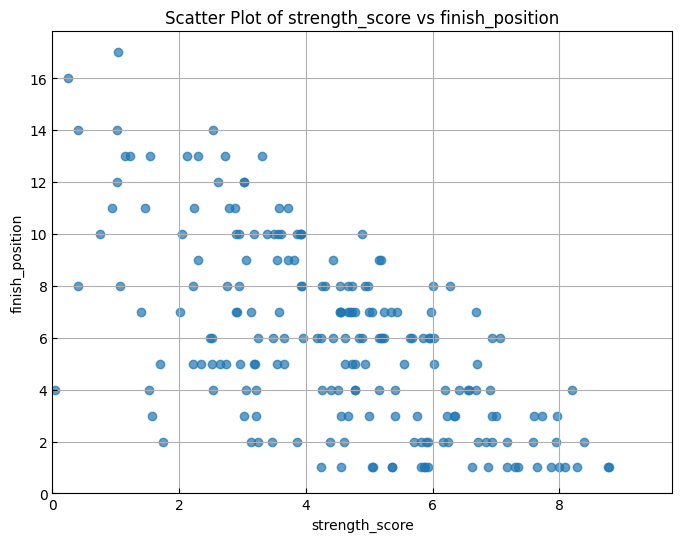

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(df["strength_score"], df["finish_position"], alpha=0.7)

plt.xlabel("strength_score")
plt.ylabel("finish_position")
plt.title("Scatter Plot of strength_score vs finish_position")
plt.tick_params(direction='in')
plt.xlim(0, df["strength_score"].max()+1)
plt.xticks(np.arange(0, df["strength_score"].max()+1, 2))
plt.yticks(np.arange(0, df["finish_position"].max()+1, 2))
plt.grid(True)
plt.show()

### Leak Model!

In [33]:
# -----------------------------
# 特徴量と目的変数の設定
# -----------------------------
features = ["age", "weight", "odds", "finish_position"]
X = df[features]
y = df["target"]

# -----------------------------
# データ分割(150:50)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

# -----------------------------
# LightGBM データセットの作成
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) # test_data を参照データとして指定

# -----------------------------
# ハイパーパラメータの設定
# -----------------------------
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

# -----------------------------
# モデルの訓練
# -----------------------------
model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

# -----------------------------
# 予測（0/1に丸める）
# -----------------------------
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

# -----------------------------
# 精度の評価
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# -----------------------------
# 予測結果を確認
# -----------------------------
results = X_test.copy()
results["actual"] = y_test
results["predicted"] = y_pred
results["predicted_prob"] = y_pred_prob

print(results.head(10))

Accuracy: 100.00%
     age  weight       odds  finish_position  actual  predicted  \
95     7     543   4.888071                1       1          1   
15     6     427   8.127804               14       0          0   
30     6     527   9.416742                7       0          0   
158    2     483   9.756491                6       0          0   
128    5     543   7.706999               10       0          0   
115    5     527   8.611836                5       0          0   
69     7     512   3.044430                7       0          0   
170    9     588   1.037077                1       1          1   
174    9     432   6.787914                6       0          0   
45     5     461  12.135225                5       0          0   

     predicted_prob  
95         0.999980  
15         0.000009  
30         0.000009  
158        0.000009  
128        0.000009  
115        0.000009  
69         0.000009  
170        0.999980  
174        0.000009  
45         0.000009  


In [34]:
# -----------------------------
# 特徴量と目的変数の設定
# -----------------------------
features = ["age", "weight", "odds"]
X = df[features]
y = df["target"]

# -----------------------------
# データ分割(150:50)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

# -----------------------------
# LightGBM データセットの作成
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) # test_data を参照データとして指定

# -----------------------------
# ハイパーパラメータの設定
# -----------------------------
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

# -----------------------------
# モデルの訓練
# -----------------------------
model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

# -----------------------------
# 予測（0/1に丸める）
# -----------------------------
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

# -----------------------------
# 精度の評価
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# -----------------------------
# 予測結果を確認
# -----------------------------
results = X_test.copy()
results["actual"] = y_test
results["predicted"] = y_pred
results["predicted_prob"] = y_pred_prob

print(results.head(10))

Accuracy: 78.00%
     age  weight       odds  actual  predicted  predicted_prob
95     7     543   4.888071       1          0        0.413570
15     6     427   8.127804       0          0        0.191794
30     6     527   9.416742       0          0        0.283141
158    2     483   9.756491       0          0        0.065150
128    5     543   7.706999       0          0        0.119303
115    5     527   8.611836       0          0        0.199332
69     7     512   3.044430       0          1        0.657367
170    9     588   1.037077       1          1        0.867171
174    9     432   6.787914       0          0        0.297707
45     5     461  12.135225       0          0        0.192278


## 完全にランダムなデータの作成

In [63]:
np.random.seed(42)
n_samples = 200

# 基本情報
df_rand = pd.DataFrame({
    "horse_id": np.arange(n_samples),
    "age": np.random.randint(2, 10, size=n_samples),
    "weight": np.random.randint(400, 600, size=n_samples),
    "odds": np.random.uniform(1.0, 20.0, size=n_samples),
    "finish_position": np.random.randint(1, 19, size=n_samples)
})

df_rand["target"] = (df_rand["finish_position"] <= 3).astype(int) # 3着以内を target=1 とする

In [64]:
print(df_rand["target"].sum())
df_rand.head(20)

36


,horse_id,age,weight,odds,finish_position,target
0,0,8,462,10.550105,10,0
1,1,5,495,11.961174,12,0
2,2,6,451,10.357836,17,0
3,3,8,495,4.709617,6,0
4,4,4,531,14.726590,7,0
5,5,9,550,6.334675,14,0
6,6,6,542,1.462003,13,0
7,7,6,570,13.263974,8,0
8,8,8,428,4.365103,10,0
9,9,3,435,18.868713,9,0


In [69]:
# -----------------------------
# 特徴量と目的変数の設定
# -----------------------------
features = ["age", "weight", "odds"]
X = df_rand[features]
y = df_rand["target"]

# -----------------------------
# データ分割(150:50)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

# -----------------------------
# LightGBM データセットの作成
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) # test_data を参照データとして指定

# -----------------------------
# ハイパーパラメータの設定
# -----------------------------
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

# -----------------------------
# モデルの訓練
# -----------------------------
model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

# -----------------------------
# 予測（0/1に丸める）
# -----------------------------
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

# -----------------------------
# 精度の評価
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# -----------------------------
# 予測結果を確認
# -----------------------------
results = X_test.copy()
results["actual"] = y_test
results["predicted"] = y_pred
results["predicted_prob"] = y_pred_prob

print(results.head(10))

Accuracy: 68.00%
     age  weight       odds  actual  predicted  predicted_prob
95     7     543  11.532727       1          0        0.397291
15     6     427   9.135499       0          0        0.131915
30     6     527  19.811023       1          1        0.520276
158    2     483  16.329860       0          0        0.243968
128    5     543  11.934009       0          0        0.438014
115    5     527  13.066779       0          0        0.408101
69     7     512   1.981953       0          0        0.287681
170    9     588  18.148505       0          0        0.354951
174    9     432  18.014941       0          1        0.524108
45     5     461  16.167608       0          0        0.128640


In [67]:
np.random.seed(42)
n_samples = 200

# 基本情報
df_rand = pd.DataFrame({
    "horse_id": np.arange(n_samples),
    "age": np.random.randint(2, 10, size=n_samples),
    "weight": np.random.randint(400, 600, size=n_samples),
    "odds": np.random.uniform(1.0, 20.0, size=n_samples),
    # "finish_position": np.random.randint(1, 19, size=n_samples)
})

# -----------------------------
# finish_position をコントロールして作る
# -----------------------------

# 58 個を「finish_position <= 3」にする
idx_high = np.random.choice(df_rand.index, size=58, replace=False)

# その 58 行を 1〜3 のランダム値にする
df_rand.loc[idx_high, "finish_position"] = np.random.randint(1, 4, size=58)

# 残り 142 行を 4〜18 にする（3着以内を target=1 にしたい場合）
idx_low = df_rand.index.difference(idx_high)
df_rand.loc[idx_low, "finish_position"] = np.random.randint(4, 19, size=len(idx_low))
# target を作成
df_rand["target"] = (df_rand["finish_position"] <= 3).astype(int)

In [68]:
print(df_rand["target"].sum())
df_rand.head(20)

58


,horse_id,age,weight,odds,finish_position,target
0,0,8,462,10.550105,18.0,0
1,1,5,495,11.961174,2.0,1
2,2,6,451,10.357836,11.0,0
3,3,8,495,4.709617,9.0,0
4,4,4,531,14.726590,17.0,0
5,5,9,550,6.334675,13.0,0
6,6,6,542,1.462003,15.0,0
7,7,6,570,13.263974,10.0,0
8,8,8,428,4.365103,3.0,1
9,9,3,435,18.868713,17.0,0


## 相関が強いデータ

In [71]:
np.random.seed(42)
n_samples = 200

# 基本情報
df_fix = pd.DataFrame({
    "horse_id": np.arange(n_samples),
    "age": np.random.randint(2, 10, size=n_samples),
    "weight": np.random.randint(400, 600, size=n_samples),
})

# -----------------------------
# 相関を持たせるためのスコア計算
# -----------------------------

# 年齢は4歳が最も強い → 4 からの距離が大きいほど弱い
age_score = np.abs(df_fix["age"] - 4)

# 体重は軽いほど強い → 400kg が最強と仮定
weight_score = (df_fix["weight"] - 400) / 50  # 50kg で1ポイント弱くなるイメージ

# 総合スコア（小さいほど強い）
strength_score = age_score + weight_score
df_fix["strength_score"] = strength_score # 特徴量には含めないが確認用に保存
# -----------------------------
# odds と finish_position を生成
# -----------------------------

# odds：強いほど（score 小）1に近づく、弱いほど大きくなる
df_fix["odds"] = 1.0 + (strength_score.max() - strength_score) 

# -----------------------------
# finish_position をコントロールして作る
# -----------------------------

# 58 個を「finish_position <= 3」にする
idx_high = np.random.choice(df_fix.index, size=58, replace=False)

# その 58 行を 1〜3 のランダム値にする
df_fix.loc[idx_high, "finish_position"] = np.random.randint(1, 4, size=58)

# 残り 142 行を 4〜18 にする（3着以内を target=1 にしたい場合）
idx_low = df_fix.index.difference(idx_high)
df_fix.loc[idx_low, "finish_position"] = np.random.randint(4, 19, size=len(idx_low))
# target を作成
df_fix["target"] = (df_fix["finish_position"] <= 3).astype(int)

In [72]:
df_fix
print(df_fix["target"].sum())

58


In [73]:
# -----------------------------
# 特徴量と目的変数の設定
# -----------------------------
features = ["age", "weight", "odds"]
X = df_fix[features]
y = df_fix["target"]

# -----------------------------
# データ分割(150:50)
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=50, random_state=42)

# -----------------------------
# LightGBM データセットの作成
# -----------------------------
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) # test_data を参照データとして指定

# -----------------------------
# ハイパーパラメータの設定
# -----------------------------
params = {
    'objective': 'binary', # 2クラス分類
    'metric': 'binary_logloss', # ロス関数
    'boosting_type': 'gbdt', # 勾配ブースティング
    'learning_rate': 0.1, # 学習率(小さいほど慎重に学習、ただし学習時間は長くなる)
    'num_leaves': 31, # 木の葉の数(複雑なモデルほど大きく)
    'verbose': -1, # 全てのログの出力を非表示
    'early_stopping_round': 30, # 30回連続で改善しなければ終了
    'num_boost_round': 300 # 最大100本の木を作成
}

# -----------------------------
# モデルの訓練
# -----------------------------
model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

# -----------------------------
# 予測（0/1に丸める）
# -----------------------------
y_pred_prob = model.predict(X_test, num_iteration=model.best_iteration)
y_pred = (y_pred_prob >= 0.5).astype(int)

# -----------------------------
# 精度の評価
# -----------------------------
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# -----------------------------
# 予測結果を確認
# -----------------------------
results = X_test.copy()
results["actual"] = y_test
results["predicted"] = y_pred
results["predicted_prob"] = y_pred_prob

print(results.head(10))

Accuracy: 64.00%
     age  weight  odds  actual  predicted  predicted_prob
95     7     543  3.92       0          0        0.191624
15     6     427  7.24       0          0        0.277675
30     6     527  5.24       1          0        0.362799
158    2     483  6.12       0          0        0.318172
128    5     543  5.92       1          0        0.362799
115    5     527  6.24       0          0        0.300483
69     7     512  4.54       0          0        0.191624
170    9     588  1.02       1          0        0.243785
174    9     432  4.14       1          0        0.191624
45     5     461  7.56       0          0        0.336025
